## Kolmogorov-Arnold Networks (KAN)

In [2]:
!pip install git+https://github.com/KindXiaoming/pykan.git@e463e6293753e485a7359ed67dd280c0ecd5cb5c

  Cloning https://github.com/KindXiaoming/pykan.git (to revision e463e6293753e485a7359ed67dd280c0ecd5cb5c) to /tmp/pip-req-build-dfb5q5fa
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-dfb5q5fa
  Running command git rev-parse -q --verify 'sha^e463e6293753e485a7359ed67dd280c0ecd5cb5c'
  Running command git fetch -q https://github.com/KindXiaoming/pykan.git e463e6293753e485a7359ed67dd280c0ecd5cb5c
  Running command git checkout -q e463e6293753e485a7359ed67dd280c0ecd5cb5c
  Resolved https://github.com/KindXiaoming/pykan.git to commit e463e6293753e485a7359ed67dd280c0ecd5cb5c
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.2.1-py3-none-any.whl size=93066 sha256=0d5bfa6379a09337bdff73aa9cca335e08af46d34d87d7ded9fec7c191bba1a2
  Stored in directory: /root/.cache/pip/wheels/91/e4/d6/1fbd96fd4758ccd83d2391671fe66343546f5676611c37f8e1
Successfully built pykan


In [3]:
# Importando bibliotecas necessárias, e o modelo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from kan import KAN
import seaborn as sns
import torch

In [4]:
# Atribuindo os dados já pré-processados às variáveis
train = pd.read_csv('train.csv')
X_train, y_train = train.drop(['satisfaction'], axis=1), train['satisfaction']

validation = pd.read_csv('validation.csv')
X_validation, y_validation = validation.drop(['satisfaction'], axis=1), validation['satisfaction']

test = pd.read_csv('test.csv')
X_test, y_test = test.drop(['satisfaction'], axis=1), test['satisfaction']

In [5]:
# Converter os DataFrames para numpy arrays
X_train = X_train.values
y_train = y_train.values
X_validation = X_validation.values
y_validation = y_validation.values
X_test = X_test.values
y_test = y_test.values

In [6]:
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.long)
validation_input = torch.tensor(X_validation, dtype=torch.float32)
validation_label = torch.tensor(y_validation, dtype=torch.long)
test_input = torch.tensor(X_test, dtype=torch.float32)
test_label = torch.tensor(y_test, dtype=torch.long)

In [7]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

In [7]:
train_losses_kan = []
test_losses_kan = []

In [8]:
def train_and_evaluate_model(width, grid, k, seed, steps, lamb, lamb_entropy):
    global train_losses_kan, test_losses_kan

    model = KAN(width=width, grid=grid, k=k, seed=seed)
    def train_acc():
        return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

    def test_acc():
        return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

    results = model.fit(dataset, opt="LBFGS", steps=steps, lamb=lamb, lamb_entropy=lamb_entropy, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())
    final_train_acc = results['train_acc'][-1]
    final_test_acc = results['test_acc'][-1]
    # Armazenando o train_loss e o test_loss
    train_losses_kan += results['train_loss']
    test_losses_kan += results['test_loss']
    print(f"Train RMSE: {results['train_loss'][-1]:.8f} | Test RMSE: {results['test_loss'][-1]:.8f}")

    # Retorna a acurácia final
    return final_train_acc, final_test_acc

In [9]:
# Definindo os parâmetros que iremos testar
param_grid = {
    'width': [[X_train.shape[1], 2]],
    'grid': [3, 5, 10, 20, 50, 100],
    'k': [2, 3],
    'seed': [0, 1, 42, 2024],
    'steps': [25, 50, 100, 250, 500, 1000, 2500, 5000],
    'lamb': [0.00, 1],
    'lamb_entropy': [0.0, 100.0]
}

In [ ]:
# Iterar sobre diferentes valores de 'grid' e 'k' para definir quais são os melhores respectivamente
best_params = None
best_accuracy = 0
seed = 0
steps = 25
lamb = 0.1
lamb_entropy = 10.0

for width in param_grid['width']:
    for grid in param_grid['grid']:
        for k in param_grid['k']:
          train_acc, test_acc = train_and_evaluate_model(width, grid, k, seed, steps, lamb, lamb_entropy)
          print(f"Width: {width}, Grid: {grid}, K: {k}, Seed: {seed}, Steps: {steps}, Lamb: {lamb}, Lamb Entropy: {lamb_entropy}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
          if test_acc > best_accuracy:
              best_accuracy = test_acc
              best_params = {
                  'width': width,
                  'grid': grid,
                  'k': k,
                  'seed': seed,
                  'steps': steps,
                  'lamb': lamb,
                  'lamb_entropy': lamb_entropy
              }

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.48e-01 | test_loss: 7.75e-01 | reg: 1.11e+01 | : 100%|█| 25/25 [12:07<00:00, 29.11s/


saving model version 0.1
Train RMSE: 0.74814951 | Test RMSE: 0.77478671
Width: [[25, 0], [2, 0]], Grid: 3, K: 2, Seed: 0, Steps: 25, Lamb: 0.1, Lamb Entropy: 10.0, Train Acc: 0.7430, Test Acc: 0.7135
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.70e-01 | test_loss: 7.69e-01 | reg: 1.27e+01 | : 100%|█| 25/25 [19:51<00:00, 47.64s/


saving model version 0.1
Train RMSE: 0.77018386 | Test RMSE: 0.76924962
Width: [[25, 0], [2, 0]], Grid: 3, K: 3, Seed: 0, Steps: 25, Lamb: 0.1, Lamb Entropy: 10.0, Train Acc: 0.6090, Test Acc: 0.6182
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.70e-01 | test_loss: 7.81e-01 | reg: 1.62e+01 | : 100%|█| 25/25 [15:29<00:00, 37.18s/


saving model version 0.1
Train RMSE: 0.77013201 | Test RMSE: 0.78082025
Width: [[25, 0], [2, 0]], Grid: 5, K: 2, Seed: 0, Steps: 25, Lamb: 0.1, Lamb Entropy: 10.0, Train Acc: 0.7249, Test Acc: 0.6969
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.67e-01 | test_loss: 1.73e+00 | reg: 2.12e+01 | : 100%|█| 25/25 [19:40<00:00, 47.21s/


saving model version 0.1
Train RMSE: 0.76696211 | Test RMSE: 1.72908199
Width: [[25, 0], [2, 0]], Grid: 5, K: 3, Seed: 0, Steps: 25, Lamb: 0.1, Lamb Entropy: 10.0, Train Acc: 0.7234, Test Acc: 0.6535
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.04e+00 | test_loss: 1.02e+00 | reg: 1.59e+01 | : 100%|█| 25/25 [25:01<00:00, 60.04s/


saving model version 0.1
Train RMSE: 1.03896499 | Test RMSE: 1.02098465
Width: [[25, 0], [2, 0]], Grid: 10, K: 2, Seed: 0, Steps: 25, Lamb: 0.1, Lamb Entropy: 10.0, Train Acc: 0.7436, Test Acc: 0.7508
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.55e-01 | test_loss: 7.56e-01 | reg: 1.63e+01 | : 100%|█| 25/25 [29:38<00:00, 71.14s/


saving model version 0.1
Train RMSE: 0.75487024 | Test RMSE: 0.75635260
Width: [[25, 0], [2, 0]], Grid: 10, K: 3, Seed: 0, Steps: 25, Lamb: 0.1, Lamb Entropy: 10.0, Train Acc: 0.7149, Test Acc: 0.7022
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.46e-01 | test_loss: 8.81e-01 | reg: 6.68e+00 | : 100%|█| 25/25 [32:07<00:00, 77.09s/


saving model version 0.1
Train RMSE: 0.84574085 | Test RMSE: 0.88073903
Width: [[25, 0], [2, 0]], Grid: 20, K: 2, Seed: 0, Steps: 25, Lamb: 0.1, Lamb Entropy: 10.0, Train Acc: 0.7234, Test Acc: 0.6993
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.52e-01 | test_loss: 7.84e-01 | reg: 1.40e+01 | : 100%|█| 25/25 [46:38<00:00, 111.95s


saving model version 0.1
Train RMSE: 0.75207984 | Test RMSE: 0.78420955
Width: [[25, 0], [2, 0]], Grid: 20, K: 3, Seed: 0, Steps: 25, Lamb: 0.1, Lamb Entropy: 10.0, Train Acc: 0.7236, Test Acc: 0.6836
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.45e-01 | test_loss: 7.61e-01 | reg: 1.55e+01 | : 100%|█| 25/25 [1:23:59<00:00, 201.6


saving model version 0.1
Train RMSE: 0.74473232 | Test RMSE: 0.76060599
Width: [[25, 0], [2, 0]], Grid: 50, K: 2, Seed: 0, Steps: 25, Lamb: 0.1, Lamb Entropy: 10.0, Train Acc: 0.7234, Test Acc: 0.6835
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.67e-01 | test_loss: 7.79e-01 | reg: 1.82e+01 | : 100%|█| 25/25 [1:47:53<00:00, 258.9


saving model version 0.1
Train RMSE: 0.76685011 | Test RMSE: 0.77947718
Width: [[25, 0], [2, 0]], Grid: 50, K: 3, Seed: 0, Steps: 25, Lamb: 0.1, Lamb Entropy: 10.0, Train Acc: 0.7234, Test Acc: 0.6837
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.43e-01 | test_loss: 7.59e-01 | reg: 1.97e+01 | : 100%|█| 25/25 [2:35:18<00:00, 372.7


saving model version 0.1
Train RMSE: 0.74294567 | Test RMSE: 0.75887710
Width: [[25, 0], [2, 0]], Grid: 100, K: 2, Seed: 0, Steps: 25, Lamb: 0.1, Lamb Entropy: 10.0, Train Acc: 0.7211, Test Acc: 0.6815
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.62e-01 | test_loss: 7.68e-01 | reg: 2.16e+01 | :  80%|▊| 20/25 [2:25:36<27:22, 328.5

Nos testes acima, vimos que a melhor acurácia de teste foi **0.7508**, e os melhores valores para 'grid e 'k' foram:

**'grid': 10**

**'k': 2**

Agora, iremos encontrar os melhores valores para 'lamb' e 'lamb_entropy'

In [10]:
# Iterar sobre diferentes valores de 'lamb' e 'lamb_entropy' para definir quais são os melhores respectivamente
best_params = None
best_accuracy = 0.7508
seed = 0
steps = 25
width = [X_train.shape[1], 2]
grid = 10
k = 2

for lamb in param_grid['lamb']:
    for lamb_entropy in param_grid['lamb_entropy']:
        train_acc, test_acc = train_and_evaluate_model(width, grid, k, seed, steps, lamb, lamb_entropy)
        print(f"Width: {width}, Grid: {grid}, K: {k}, Seed: {seed}, Steps: {steps}, Lamb: {lamb}, Lamb Entropy: {lamb_entropy}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_params = {
                'width': width,
                'grid': grid,
                'k': k,
                'seed': seed,
                'steps': steps,
                'lamb': lamb,
                'lamb_entropy': lamb_entropy
            }

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e+00 | test_loss: 1.65e+00 | reg: 1.00e+00 | : 100%|█| 25/25 [22:09<00:00, 53.16s/


saving model version 0.1
Train RMSE: 1.56932378 | Test RMSE: 1.64992881
Width: [[25, 0], [2, 0]], Grid: 10, K: 2, Seed: 0, Steps: 25, Lamb: 0.0, Lamb Entropy: 0.0, Train Acc: 0.6845, Test Acc: 0.6676
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.57e+00 | test_loss: 1.65e+00 | reg: 5.99e+01 | : 100%|█| 25/25 [22:30<00:00, 54.01s/


saving model version 0.1
Train RMSE: 1.56932378 | Test RMSE: 1.64992881
Width: [[25, 0], [2, 0]], Grid: 10, K: 2, Seed: 0, Steps: 25, Lamb: 0.0, Lamb Entropy: 100.0, Train Acc: 0.6845, Test Acc: 0.6676
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e+00 | test_loss: 1.70e+00 | reg: 1.05e+00 | : 100%|█| 25/25 [25:15<00:00, 60.60s/


saving model version 0.1
Train RMSE: 1.68782806 | Test RMSE: 1.70073545
Width: [[25, 0], [2, 0]], Grid: 10, K: 2, Seed: 0, Steps: 25, Lamb: 1, Lamb Entropy: 0.0, Train Acc: 0.5614, Test Acc: 0.5502
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.32e+00 | test_loss: 3.13e+00 | reg: 1.25e+02 | : 100%|█| 25/25 [22:13<00:00, 53.34s/

saving model version 0.1
Train RMSE: 3.31622291 | Test RMSE: 3.13369584
Width: [[25, 0], [2, 0]], Grid: 10, K: 2, Seed: 0, Steps: 25, Lamb: 1, Lamb Entropy: 100.0, Train Acc: 0.5708, Test Acc: 0.6008


In [11]:
print(f"Best parameters: {best_params}")
print(f"Best test accuracy: {best_accuracy:.4f}")

Best parameters: None
Best test accuracy: 0.7508


Não houve nenhuma melhoria em relação aos testes anteriores. Os melhores valores para os parâmetros continuam os mesmos:

**'grid' = 10**

**'k' = 2**

**'lamb' = 0.1**

**'lamb_entropy' = 10.0**

Iremos testar manualmente com outros valores

In [12]:
grid = 3
k = 2
seed = 0
steps = 20
lamb = 0.1
lamb_entropy = 10.0
width = [X_train.shape[1], 2]

train_acc, test_acc = train_and_evaluate_model(width, grid, k, seed, steps, lamb, lamb_entropy)
print(f"Width: {width}, Grid: {grid}, K: {k}, Seed: {seed}, Steps: {steps}, Lamb: {lamb}, Lamb Entropy: {lamb_entropy}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.65e-01 | test_loss: 7.63e-01 | reg: 1.61e+01 | : 100%|█| 20/20 [07:12<00:00, 21.62s/

saving model version 0.1
Train RMSE: 0.76473588 | Test RMSE: 0.76295990
Width: [[25, 0], [2, 0]], Grid: 3, K: 2, Seed: 0, Steps: 20, Lamb: 0.1, Lamb Entropy: 10.0, Train Acc: 0.7011, Test Acc: 0.7026
Test accuracy: 0.7026


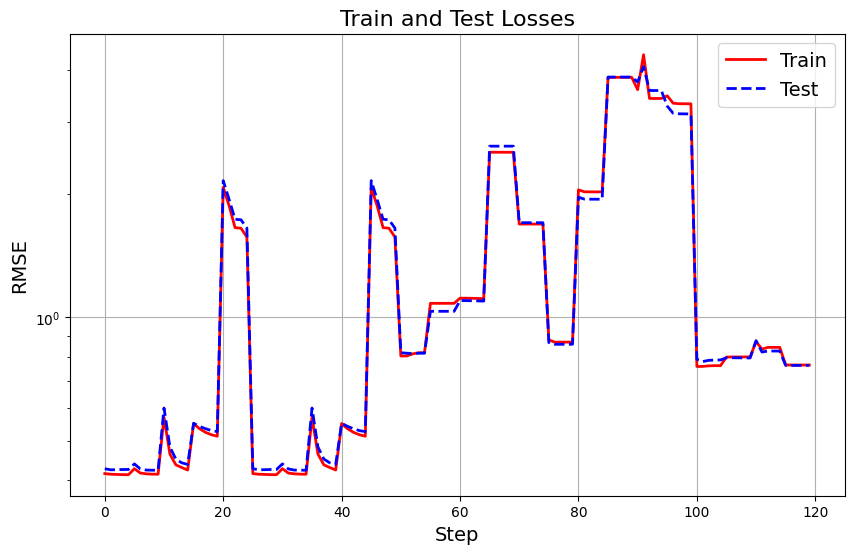

In [13]:
plt.figure(figsize=(10, 6))  # Increase the size of the figure
plt.plot(train_losses_kan, 'r-', linewidth=2)  # Change the line color to red and increase the line width
plt.plot(test_losses_kan, 'b--', linewidth=2)  # Change the line color to blue, use dashed line style and increase the line width
plt.legend(['Train', 'Test'], fontsize=14)
plt.title('Train and Test Losses', fontsize=16)
plt.ylabel('RMSE', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.yscale('log')
plt.grid(True)  # Add a grid
plt.show()

Vamos redefinir a função train_and_evaluate_model para retirar alguns parâmetros, e comparar o resultado

In [17]:
train_losses_kan_second = []
test_losses_kan_second = []

In [18]:
def train_and_evaluate_model_second(width, grid, k, steps):
    global train_losses_kan_second, test_losses_kan_second

    model = KAN(width=width, grid=grid, k=k)
    def train_acc():
        return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

    def test_acc():
        return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

    results = model.fit(dataset, opt="LBFGS", steps=steps, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())
    final_train_acc = results['train_acc'][-1]
    final_test_acc = results['test_acc'][-1]
    # Armazenando o train_loss e o test_loss
    train_losses_kan_second += results['train_loss']
    test_losses_kan_second += results['test_loss']
    print(f"Train RMSE: {results['train_loss'][-1]:.8f} | Test RMSE: {results['test_loss'][-1]:.8f}")

    # Retorna a acurácia final
    return final_train_acc, final_test_acc

In [19]:
param_grid_second = {
    'width': [[X_train.shape[1], 2]],
    'grid': [2, 3, 10],
    'k': [2, 3],
    'steps': [20]
}

In [20]:
best_accuracy = 0
best_params = None

# Iterar sobre todas as combinações de hiperparâmetros acima
for width in param_grid_second['width']:
    for grid in param_grid_second['grid']:
        for k in param_grid_second['k']:
            for steps in param_grid_second['steps']:
                train_acc, test_acc = train_and_evaluate_model_second(width, grid, k, steps)
                print(f"Width: {width}, Grid: {grid}, K: {k}, Steps: {steps}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

                if test_acc > best_accuracy:
                    best_accuracy = test_acc
                    best_params = {
                    'width': width,
                    'grid': grid,
                    'k': k,
                    'steps': steps,
                  }

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.32e-01 | test_loss: 4.40e-01 | reg: 9.11e+00 | : 100%|█| 20/20 [05:43<00:00, 17.19s/


saving model version 0.1
Train RMSE: 0.43224403 | Test RMSE: 0.43983889
Width: [[25, 0], [2, 0]], Grid: 2, K: 2, Steps: 20, Train Acc: 0.9305, Test Acc: 0.9266
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.20e-01 | test_loss: 4.74e-01 | reg: 8.88e+00 | : 100%|█| 20/20 [08:25<00:00, 25.25s/


saving model version 0.1
Train RMSE: 0.42005154 | Test RMSE: 0.47414055
Width: [[25, 0], [2, 0]], Grid: 2, K: 3, Steps: 20, Train Acc: 0.9353, Test Acc: 0.9105
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.22e-01 | test_loss: 4.31e-01 | reg: 6.89e+00 | : 100%|█| 20/20 [05:45<00:00, 17.30s/


saving model version 0.1
Train RMSE: 0.42200130 | Test RMSE: 0.43106261
Width: [[25, 0], [2, 0]], Grid: 3, K: 2, Steps: 20, Train Acc: 0.9339, Test Acc: 0.9305
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.14e-01 | test_loss: 4.23e-01 | reg: 8.91e+00 | : 100%|█| 20/20 [09:19<00:00, 27.98s/


saving model version 0.1
Train RMSE: 0.41423866 | Test RMSE: 0.42308965
Width: [[25, 0], [2, 0]], Grid: 3, K: 3, Steps: 20, Train Acc: 0.9366, Test Acc: 0.9342
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.17e-01 | test_loss: 5.32e-01 | reg: 2.46e+00 | : 100%|█| 20/20 [15:16<00:00, 45.83s/


saving model version 0.1
Train RMSE: 0.51743907 | Test RMSE: 0.53202027
Width: [[25, 0], [2, 0]], Grid: 10, K: 2, Steps: 20, Train Acc: 0.8992, Test Acc: 0.8941
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.13e-01 | test_loss: 4.25e-01 | reg: 8.84e+00 | : 100%|█| 20/20 [23:16<00:00, 69.84s/

saving model version 0.1
Train RMSE: 0.41277221 | Test RMSE: 0.42535779
Width: [[25, 0], [2, 0]], Grid: 10, K: 3, Steps: 20, Train Acc: 0.9372, Test Acc: 0.9336


In [21]:
print(f"Best parameters: {best_params}")
print(f"Best test accuracy: {best_accuracy:.4f}")

Best parameters: {'width': [[25, 0], [2, 0]], 'grid': 3, 'k': 3, 'steps': 20}
Best test accuracy: 0.9342


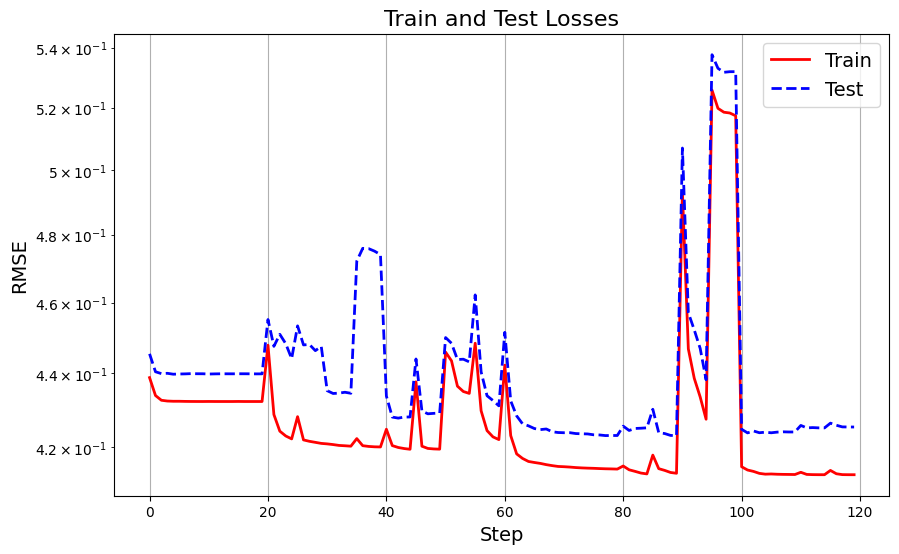

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_kan_second, 'r-', linewidth=2)
plt.plot(test_losses_kan_second, 'b--', linewidth=2)
plt.legend(['Train', 'Test'], fontsize=14)
plt.title('Train and Test Losses', fontsize=16)
plt.ylabel('RMSE', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.yscale('log')
plt.grid(True)  # Add a grid
plt.show()

### Modelo final

In [8]:
final_model = KAN(width=[[25, 0], [2, 0]], grid=3, k=3)
def train_acc():
    return torch.mean((torch.argmax(final_model(dataset['train_input']), dim=1) == dataset['train_label']).float())
def test_acc():
    return torch.mean((torch.argmax(final_model(dataset['test_input']), dim=1) == dataset['test_label']).float())

results = final_model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())
final_train_acc = results['train_acc'][-1]
final_test_acc = results['test_acc'][-1]
print(f"Train RMSE: {results['train_loss'][-1]:.8f} | Test RMSE: {results['test_loss'][-1]:.8f}")
print(f"Best train accuracy: {final_train_acc:.4f}")
print(f"Best test accuracy: {final_test_acc:.4f}")

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.14e-01 | test_loss: 4.23e-01 | reg: 8.91e+00 | : 100%|█| 20/20 [16:11<00:00, 48.59s/

saving model version 0.1
Train RMSE: 0.41423866 | Test RMSE: 0.42308965
Best train accuracy: 0.9366
Best test accuracy: 0.9342


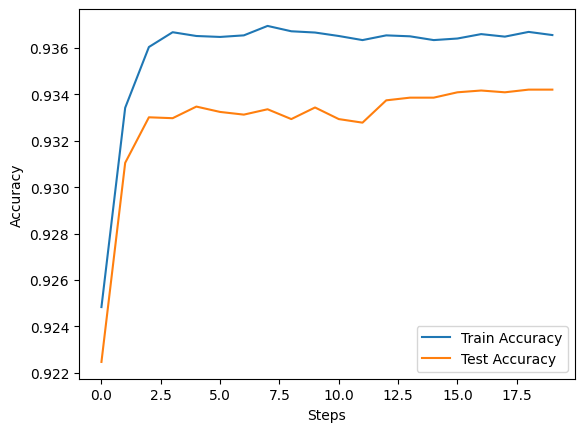

In [9]:
plt.plot(results['train_acc'], label='Train Accuracy')
plt.plot(results['test_acc'], label='Test Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
test_outputs = final_model(dataset['test_input'])

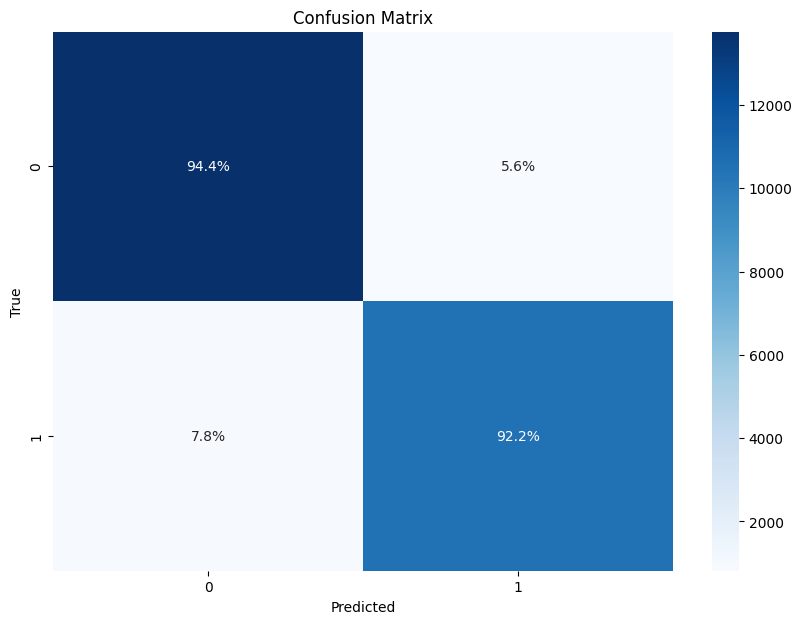

In [28]:
# Matriz de confusão
def plot_confusion_matrix(model, dataset, y_test):
    # Codificar rótulos
    label_encoder = LabelEncoder()
    encoded_y_test = label_encoder.fit_transform(y_test)

    test_predictions = torch.argmax(test_outputs, dim=1).cpu().numpy()
    conf_matrix = confusion_matrix(encoded_y_test, test_predictions)

    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = np.divide(conf_matrix, row_sums, where=row_sums != 0) * 100

    annot_labels = np.array([['{:.1f}%'.format(value) for value in row] for row in conf_matrix_percent])

    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=annot_labels, fmt='', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')

    plt.show()

plot_confusion_matrix(final_model, dataset, y_test)

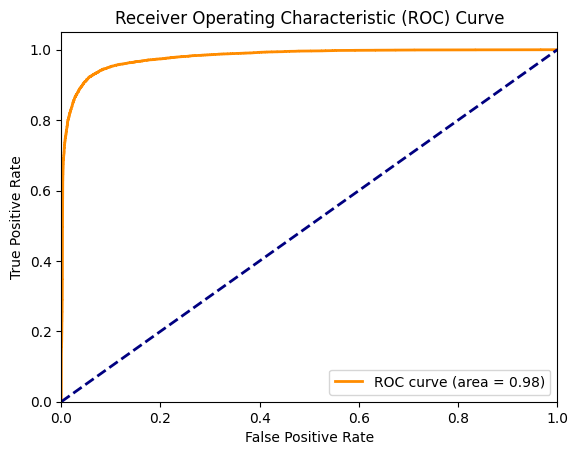

In [32]:
# Curva ROC
test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()
fpr, tpr, _ = roc_curve(y_test, test_probs[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [33]:
# Kolmogorov-Smirnov
ks_statistic = np.max(tpr - fpr)
print(f"KS Statistic: {ks_statistic:.2f}")

KS Statistic: 0.87


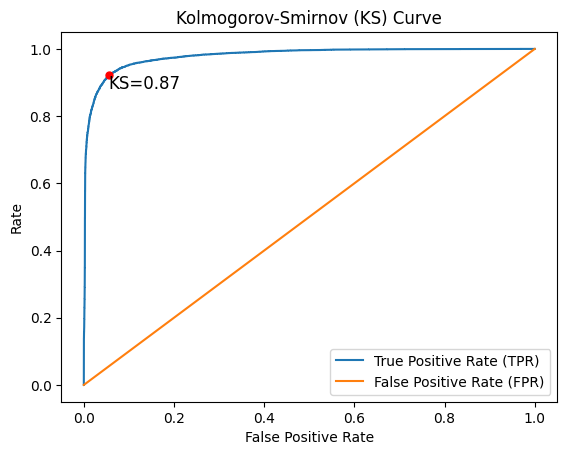

In [34]:
# Kolmogorov-Smirnov
ks_idx = np.argmax(tpr - fpr)
plt.figure()
plt.plot(fpr, tpr, label='True Positive Rate (TPR)')
plt.plot(fpr, fpr, label='False Positive Rate (FPR)')
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], marker='o', markersize=5, color="red")
plt.text(fpr[ks_idx], tpr[ks_idx], f'KS={ks_statistic:.2f}', fontsize=12, verticalalignment='top')
plt.xlabel('False Positive Rate')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.legend(loc='best')
plt.show()

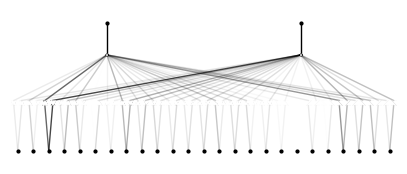

In [35]:
final_model.plot()